# EfficientNetV2 Tutorial: inference, eval, and training 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientnetv2/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientnetv2/tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

# 0. Install and view graph.

## 0.1 Install package and download source code/image.



In [ ]:
%%capture
#@title
!pip install tensorflow_addons

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientnetv2" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientnetv2')
  sys.path.append('.')
else:
  !git pull

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
    !tar zxf {m}.tgz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

## 0.2 View graph in TensorBoard

In [ ]:
MODEL = 'efficientnetv2-b0'  #@param
import effnetv2_model

with tf.compat.v1.Graph().as_default():
  model = effnetv2_model.EffNetV2Model(model_name=MODEL)
  _ = model(tf.ones([1, 224, 224, 3]), training=False)
  tf.io.gfile.mkdir('tb')
  train_writer = tf.summary.FileWriter('tb')
  train_writer.add_graph(tf.get_default_graph())
  train_writer.flush()

%load_ext tensorboard
%tensorboard --logdir tb

# 1. inference

In [ ]:
MODEL = 'efficientnetv2-b0'  #@param

# Download checkpoint.
ckpt_path = download(MODEL)
if tf.io.gfile.isdir(ckpt_path):
  ckpt_path = tf.train.latest_checkpoint(ckpt_path)

# Download label map file
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.txt -O labels_map.txt
labels_map = 'labels_map.txt'

# Download images
image_file = 'panda.jpg'
!wget https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG -O {image_file}

INFO:tensorflow:Use default resize_bicubic.


top 1 (86.9%):  giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 
top 2 (0.4%):  lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens 
top 3 (0.2%):  French bulldog 
top 4 (0.1%):  ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus 
top 5 (0.1%):  American black bear, black bear, Ursus americanus, Euarctos americanus 


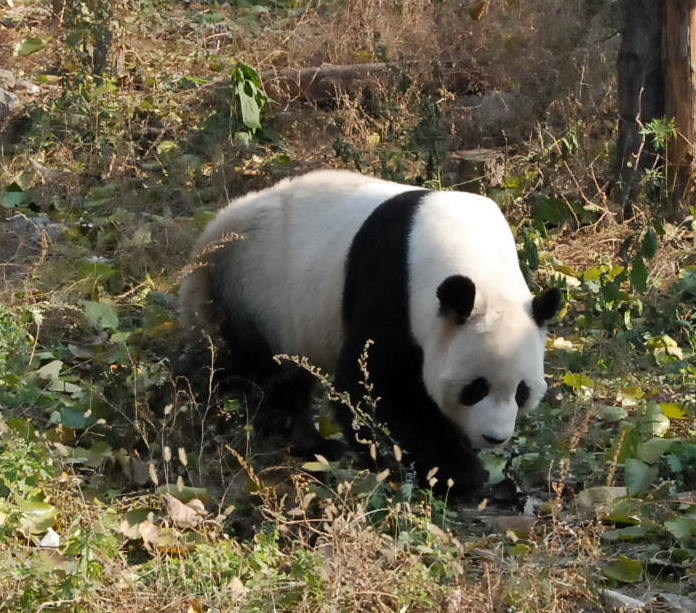

In [ ]:
# Build model
tf.keras.backend.clear_session()
model = effnetv2_model.EffNetV2Model(model_name=MODEL)
_ = model(tf.ones([1, 224, 224, 3]), training=False)
model.load_weights(ckpt_path)
cfg = model.cfg

# Run inference for a given image
import preprocessing
image = tf.io.read_file(image_file)
image = preprocessing.preprocess_image(
    image, cfg.eval.isize, is_training=False, augname=cfg.data.augname)
logits = model(tf.expand_dims(image, 0), False)

# Output classes and probability
pred = tf.keras.layers.Softmax()(logits)
idx = tf.argsort(logits[0])[::-1][:5].numpy()
import ast
classes = ast.literal_eval(open(labels_map, "r").read())
for i, id in enumerate(idx):
  print(f'top {i+1} ({pred[0][id]*100:.1f}%):  {classes[id]} ')
from IPython import display
display.display(display.Image(image_file))

# 2. Finetune EfficientNetV2 on CIFAR10.

In [ ]:
!python main_tf2.py --mode=traineval  --model_name=efficientnetv2-b0  --dataset_cfg=cifar10Ft --model_dir={MODEL}_finetune --hparam_str="train.ft_init_ckpt={MODEL},runtime.strategy=gpus,train.batch_size=64"


2021-05-21 06:57:45.007054: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-21 06:57:47.527999: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-21 06:57:47.530541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-21 06:57:47.536579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-21 06:57:47.537108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-05-21 06:57:47.537141: I tensorflow/stream_executor/platform/default/dso_loade